<a href="https://colab.research.google.com/github/tpavan03/Phishing-Detection/blob/main/ModelExplainability_Captum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
df=pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")

In [2]:
X = df.drop([ 'FILENAME','Domain','TLD','URL', 'Title','label'], axis=1)  # Drop unnecessary columns
y = df['label']
X.fillna(0, inplace=True)
y.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
from sklearn.preprocessing import MinMaxScaler

all_columns = df.columns.tolist()

numerical_features = [col for col in all_columns if col not in ['FILENAME', 'Domain', 'TLD', 'URL', 'Title', 'label']]

X = df[numerical_features]

scaler = MinMaxScaler()
scaler.fit(X)

X_normalized = scaler.transform(X)

df[numerical_features] = X_normalized

In [4]:

!pip install captum aix360 torchray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.2/376.2 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 29.6 MB/s eta 0:00:00
  Created wheel for torchray: filename=torchray-1.0.0.2-py3-none-any.whl size=444011 sha256=b1dd9da5d30b52e724d2cfb16c01ea11e73ccf88006237a3fcd5ac60262c80a8
  Stored in directory: /root/.cache/pip/wheels/67/89/6f/9f783db1b9c9c2f31323a990f12e156e4f99d9ae15c9a2e96c
Successfully built torchray


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert Pandas DataFrames to NumPy arrays before creating tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)  # Reshape for output
X_test_tensor = torch.FloatTensor(X_test.values)

In [6]:
print(X_train_tensor.shape)

torch.Size([165056, 50])


In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.output(x))
        return x

# Initialize the model
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)

In [8]:
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
num_epochs = 5
batch_size = 32
num_batches = len(X_train_tensor) // batch_size

for epoch in range(num_epochs):
    model.train()
    for i in range(num_batches):
        # Get batch data
        start = i * batch_size
        end = start + batch_size
        X_batch = X_train_tensor[start:end]
        y_batch = y_train_tensor[start:end]

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.0031
Epoch [2/5], Loss: 0.0010
Epoch [3/5], Loss: 0.0009
Epoch [4/5], Loss: 0.0008
Epoch [5/5], Loss: 0.0002


In [10]:

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    y_pred_probs = model(X_test_tensor).numpy()
    y_pred = (y_pred_probs > 0.5).astype(int)
print(y_pred)

[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [1]]


In [11]:
outputs = model(X_train_tensor)
print(outputs.shape)

torch.Size([165056, 1])


In [12]:

from captum.attr import IntegratedGradients
# Extract a single input sample from X_train_tensor
input_tensor = X_train_tensor[0].unsqueeze(0)  # Take the first sample and add batch dimension

target_label = torch.tensor(1)

# Initialize the Integrated Gradients
ig = IntegratedGradients(model)

# Compute attributions for the input samples with respect to the target class
attributions, delta = ig.attribute(input_tensor, return_convergence_delta=True)

# Print attributions and delta for interpretation of values
print('Attributions:', attributions)
print('Delta (convergence check):', delta)

Attributions: tensor([[-2.6606e-01, -7.3776e-02, -0.0000e+00,  6.0592e-01, -9.6447e-03,
         -4.9981e-05, -4.0192e-04, -2.5153e-02,  1.4233e-04, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -1.3502e-01, -5.5910e-03, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -2.5802e-02,
         -9.9334e-04,  2.6902e-02,  6.4885e-01, -7.3297e-01, -7.8631e-03,
          0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00, -6.0131e-03,
         -0.0000e+00,  0.0000e+00,  2.5499e-02, -0.0000e+00,  0.0000e+00,
         -0.0000e+00,  3.0513e-02,  5.3286e-04,  2.6243e-03, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00,  1.2958e-02,  7.2483e-02,
          7.3994e-02,  1.1255e-01,  5.1726e-01, -7.0103e-04,  5.1748e-02]],
       dtype=torch.float64)
Delta (convergence check): tensor([-0.0041], dtype=torch.float64)


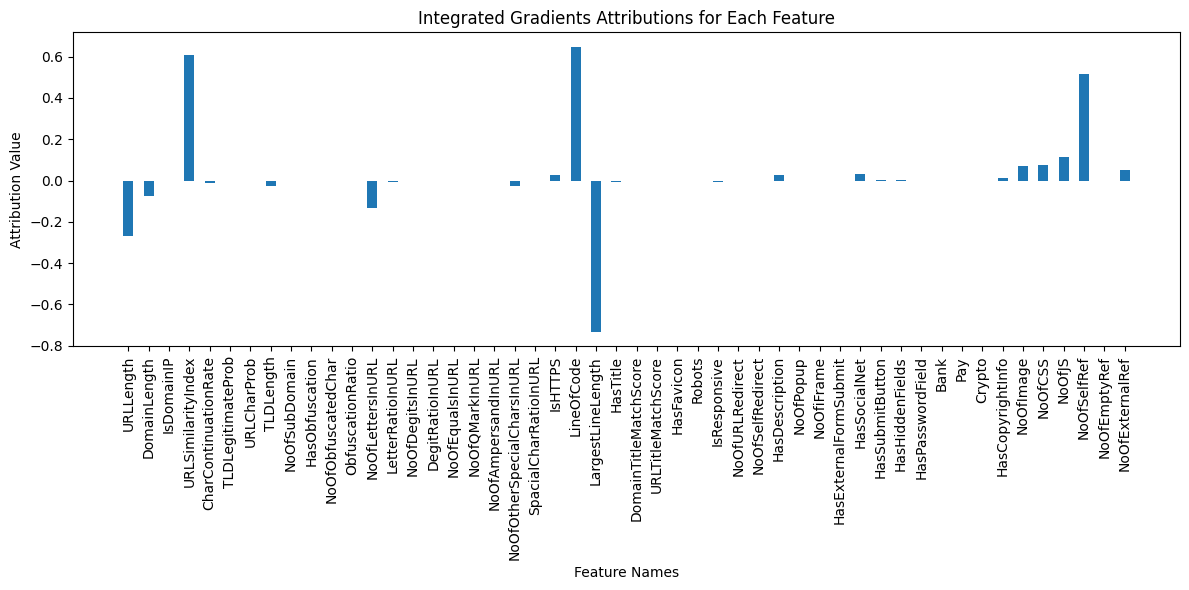

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

x_pos = np.arange(len(X_train.columns))
plt.bar(x_pos, attributions_np, width=0.5)
plt.xticks(x_pos, X_train.columns, rotation=90)
plt.xlabel('Feature Names')
plt.ylabel('Attribution Value')
plt.title('Integrated Gradients Attributions for Each Feature')
plt.tight_layout()
plt.show()

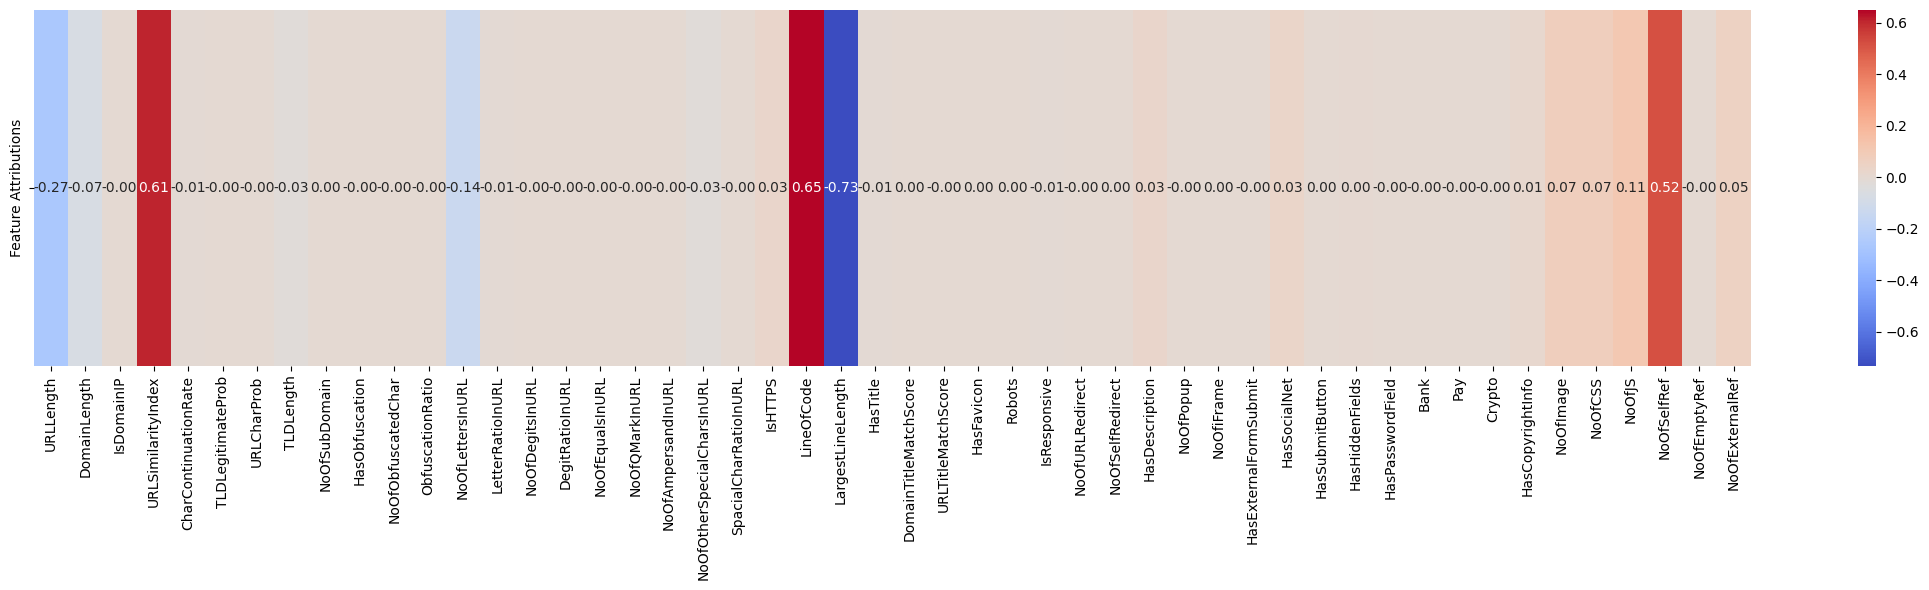

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape attributions for heatmap
attributions_heatmap = attributions_np.reshape(1, -1)

# Create heatmap
plt.figure(figsize=(22, 6))
sns.heatmap(attributions_heatmap, annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=X_train.columns, yticklabels=["Feature Attributions"])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [20]:
dominant_feature_index = 22  # Index of the dominant feature
dominant_feature_name = X_train.columns[dominant_feature_index]  # Get the column name

# Print the dominant feature name and its attribution value
print(f"The dominant feature is '{dominant_feature_name}' at index {dominant_feature_index} with an attribution value of {attributions_np[dominant_feature_index]}")


The dominant feature is 'LineOfCode' at index 22 with an attribution value of 0.6488529024090983


In [26]:
attributions.dim()

2

# **FAITHFULNESS CHECK**
We will check the faithfulness of the model by removing the top 5 attributes with highest integrated gradients and check the new accuracy of model

In [28]:
# Convert attributions to a numpy array and take the mean across the first axis
mean_attributions = attributions.detach().numpy().mean(axis=0)

# Ensure mean_attributions has the same length as X_train.columns
mean_attributions = mean_attributions[:len(X_train.columns)]

# Get indices of top 5 features
top_indices = mean_attributions.argsort()[-5:][::-1]

# Get top 5 feature names and their corresponding attributions
top_features = [(X_train.columns[i], mean_attributions[i], i) for i in top_indices]

# Print the results
for feature_name, attribution_value, index in top_features:
    print(f"Feature: {feature_name}, Attribution: {attribution_value:.4f}, Index: {index}")


Feature: LineOfCode, Attribution: 0.6489, Index: 22
Feature: URLSimilarityIndex, Attribution: 0.6059, Index: 3
Feature: NoOfSelfRef, Attribution: 0.5173, Index: 47
Feature: NoOfJS, Attribution: 0.1126, Index: 46
Feature: NoOfCSS, Attribution: 0.0740, Index: 45


In [32]:
# Create a copy of the test dataset
X_test_ablation = X_test_tensor.clone()
for idx in top_indices:
    X_test_ablation[:, idx] = 0  # Set the important features to zero

In [33]:
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)  # Reshape for output

In [35]:
criterion = torch.nn.BCELoss()
correct = 0
total = 0

# Perform training on the  data after feature removal
with torch.no_grad():
    outputs = model(X_test_ablation)
    predicted = (outputs > 0.5).float()

    # Calculate accuracy
    correct += (predicted == y_test_tensor).sum().item()
    total += y_test_tensor.size(0)

accuracy_after_ablation = correct / total
print(f"Accuracy after discarding top features: {accuracy_after_ablation}")

Accuracy after discarding top features: 0.5541214888533906


In [36]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

with torch.no_grad():
    outputs = model(X_test_ablation)
    predicted = (outputs > 0.5).float()  # Binary classification (threshold at 0.5)

    # Convert predicted and true labels to numpy for metric calculations
    predicted_np = predicted.numpy()
    y_test_np = y_test_tensor.numpy()

    # Calculate accuracy and other metrics
    accuracy_after_ablation = accuracy_score(y_test_np, predicted_np)
    precision_after_ablation = precision_score(y_test_np, predicted_np)
    recall_after_ablation = recall_score(y_test_np, predicted_np)
    f1_after_ablation = f1_score(y_test_np, predicted_np)

print(f"Accuracy after ablating top features: {accuracy_after_ablation:.4f}")
print(f"Precision after ablating top features: {precision_after_ablation:.4f}")
print(f"Recall after ablating top features: {recall_after_ablation:.4f}")
print(f"F1 Score after ablating top features: {f1_after_ablation:.4f}")

Accuracy after ablating top features: 0.5541
Precision after ablating top features: 1.0000
Recall after ablating top features: 0.2229
F1 Score after ablating top features: 0.3645


In [54]:
with torch.no_grad():
    outputs_original = model(X_test_tensor)
    predicted_original = (outputs_original > 0.5).float()

    correct_original = (predicted_original == y_test_tensor).sum().item()
    accuracy_original = correct_original / total
    print(f"Original accuracy: {accuracy_original}")

# Compare the accuracies
performance_drop = accuracy_original - accuracy_after_ablation
print(f"Performance drop after features removal: {performance_drop}")

Original accuracy: 0.9993355857447801
Performance drop after features removal: 0.44521409689138947


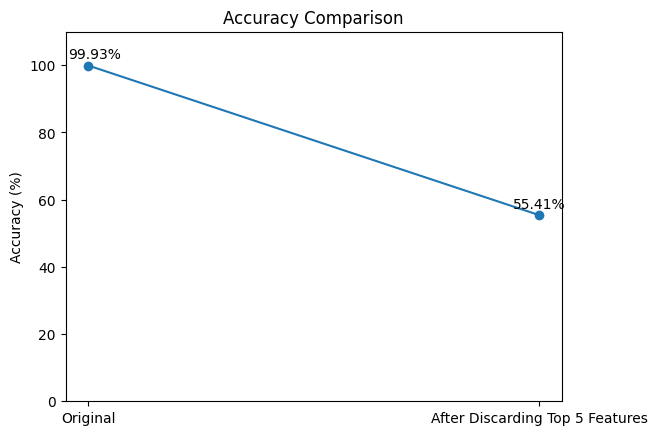

In [53]:
import matplotlib.pyplot as plt

accuracies = [accuracy_original * 100, accuracy_after_ablation * 100]
labels = ['Original', 'After Discarding Top 5 Features']

plt.plot(labels, accuracies, marker='o')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
plt.ylim([0, 110])
for i, accuracy in enumerate(accuracies):
    x_pos = labels[i] if i != 0 else +0.015
    plt.text(x_pos, accuracy + 2, f'{accuracy:.2f}%', ha='center')  # Offset vertically to avoid overlap

plt.show()
